In [2]:

from fastai.vision.all import *


import fastai
print(fastai.__version__)

from fastcore.xtras import Path

from fastai.callback.hook import summary
from fastai.callback.progress import ProgressCallback
from fastai.callback.schedule import lr_find, fit_flat_cos

from fastai.data.block import DataBlock
from fastai.data.external import untar_data, URLs
from fastai.data.transforms import get_image_files, FuncSplitter, Normalize

from fastai.layers import Mish
from fastai.losses import BaseLoss
from fastai.optimizer import ranger

from fastai.torch_core import tensor

from fastai.vision.augment import *
from fastai.vision.core import PILImage, PILMask
from fastai.vision.data import ImageBlock, MaskBlock, imagenet_stats
from fastai.vision.learner import unet_learner

from PIL import Image
import numpy as np

from torch import nn
from torchvision.models.resnet import resnet34

import torch
import torch.nn.functional as F

from fastai.data.all import *
from fastai.vision.core import *
from fastai.vision.data import *


import torch
from fastai.vision import *
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
from fastai.callback.tensorboard import *
#from fastai.callbacks import CSVLogger
#from fastai.callbacks.tensorboard import LearnerTensorboardWriter
#from tensorboardX import SummaryWriter
import pandas as pd
import torch
from fastai.vision import *
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
#from fastai.callbacks import CSVLogger
import sys

from os.path import join as opj

2.4.1


In [3]:

projectDir = '/scicore/home/pissal00/ercan0000/220310_training'
projectPath = Path(projectDir)

path  = projectPath/'GT'

# Our validation set is inside a text document called `valid.txt` and split by new lines. Let's read it in:
valid_fnames = (path/'valid.txt').read_text().split('\n')
# Let's look at an image and see how everything aligns up



path_im = path/'images'
path_lbl = path/'labels'




fnames = get_image_files(path_im)
lbl_names = get_image_files(path_lbl)




img_fn = fnames[1]
img = PILImage.create(img_fn)
#img.show(figsize=(5,5))



get_msk = lambda o: path_lbl/f'{o.stem}-labelled.png'


msk = PILMask.create(get_msk(img_fn))
#msk.show(figsize=(5,5), alpha=0.5)



codes = np.loadtxt(path/'codes.txt', dtype=str)#; codes



def FileSplitter(fname):
    "Split `items` depending on the value of `mask`."
    valid = Path(fname).read_text().split('\n') 
    def _func(x): return x.name in valid
    def _inner(o, **kwargs): return FuncSplitter(_func)(o)
    return _inner



xtra_tfms = (Brightness(p=0.75), Contrast(p=0.75),Saturation(max_lighting=0.2, p=0.75))
 

stroma = DataBlock(blocks=(ImageBlock, MaskBlock(codes)),
                get_items=get_image_files,
                splitter=FileSplitter(path/'valid.txt'),
                #splitter=TrainTestSplitter(test_size=0.2),
                get_y=get_msk,
                #item_tfms=aug_transforms(do_flip=True, flip_vert=True),
                #item_tfms=[SegmentationAlbumentationsTransform(transformPipeline)],
                batch_tfms=[*aug_transforms(do_flip=True, flip_vert=True, max_lighting=0.2, max_warp=0.2, p_affine=0.25, p_lighting=0.75, xtra_tfms=xtra_tfms), Normalize.from_stats(*imagenet_stats)])    

BS =32

dls = stroma.dataloaders(path/'images', bs=BS)

dls.vocab = codes

name2id = {v:k for k,v in enumerate(codes)}


name2id




void_code = name2id['Void']
bkg_dbrs_code = name2id['Debris_Background']




def Accuracy_Overall(inp, targ, void_idx=void_code, axis=1):
    "Computes non-background accuracy for multiclass segmentation"
    #https://github.com/fastai/fastai/blob/aeb5317d11d986420fde85fc9749aac1f53eefd6/fastai/metrics.py#L323
    targ = cast(targ.squeeze(1), TensorBase)
    mask = targ != void_idx
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()

def Accuracy_nonBackground(inp, targ, void_idx=void_code, bkg_dbrs_idx=bkg_dbrs_code, axis=1):
    "Computes non-background accuracy for multiclass segmentation"
    #https://github.com/fastai/fastai/blob/aeb5317d11d986420fde85fc9749aac1f53eefd6/fastai/metrics.py#L323
    targ = cast(targ.squeeze(1), TensorBase)
    mask = targ != void_idx & bkg_dbrs_idx 
    return (inp.argmax(dim=axis)[mask]==targ[mask]).float().mean()





opt = ranger


class IOU(AvgMetric):
    "Intersection over Union Metric"
    def __init__(self, class_index, class_label, axis): store_attr('axis,class_index,class_label')
    def accumulate(self, learn):
        pred, targ = learn.pred.argmax(dim=self.axis), learn.y
        intersec = ((pred == targ) & (targ == self.class_index)).sum().item()
        union = (((pred == self.class_index) | (targ == self.class_index))).sum().item()
        if union: self.total += intersec
        self.count += union
  
    @property
    def name(self): return self.class_label

metrics = [
    #MIOU(3, axis=1), 
    Accuracy_Overall,Accuracy_nonBackground,DiceMulti(axis=1), JaccardCoeff(axis=1)]

for x in range(1,4): metrics.append(IOU(x, codes[x], axis=1))

lr = 7e-4


In [4]:
learn = unet_learner(dls,
                     resnet34,
                     metrics=metrics,
                     self_attention=True,
                     act_cls=Mish,
                     loss_func=CrossEntropyLossFlat(axis=1),
                     wd=1e-1,
                     opt_func=opt).to_fp16()

/scicore/home/pissal00/ercan0000/.conda/envs/fastai2/lib/python3.7/site-packages/torch/cuda/amp/autocast_mode.py:118: UserWarning: torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.autocast only affects CUDA ops, but CUDA is not available.  Disabling.")


In [5]:

learn.path=projectPath/'output'

In [6]:
loadedModel = "best_unet-resnet34_before-unfreeze-WD-1_BS32_20220315_0838"

In [7]:
learn.load(loadedModel)

In [12]:
outputDir = opj(projectDir,'output')

res_plot_path = opj(outputDir,'plots',loadedModel+'results_stage-1.png')


In [13]:
%matplotlib inline

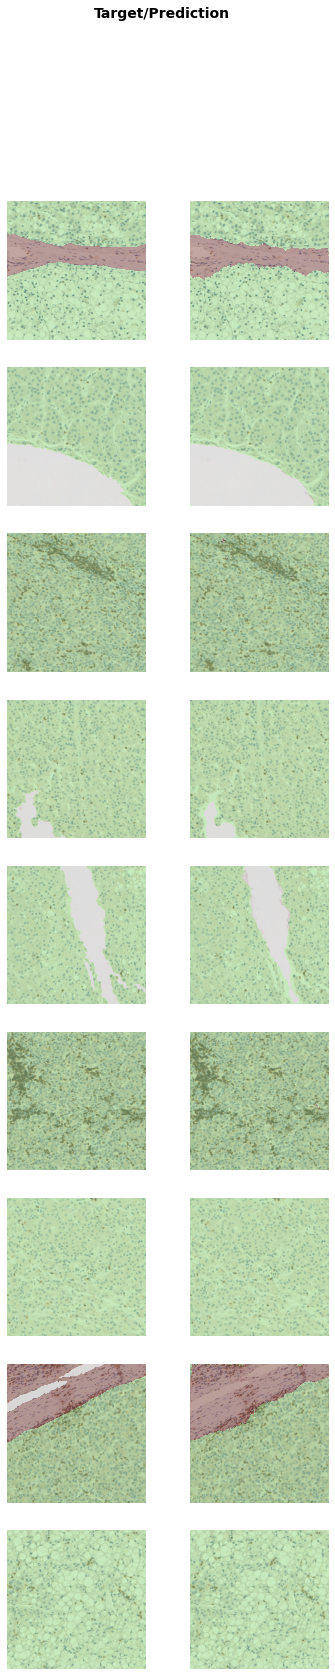

In [15]:
learn.show_results()

plt.savefig(res_plot_path)

In [16]:
interp = SegmentationInterpretation.from_learner(learn)
interp.plot_top_losses(k=2)

KeyboardInterrupt: 

In [1]:
import socket    
hostname = socket.gethostname()    
IPAddr = socket.gethostbyname(hostname)    
print("Your Computer Name is:" + hostname)    
print("Your Computer IP Address is:" + IPAddr) 

Your Computer Name is:shi20.cluster.bc2.ch
Your Computer IP Address is:10.1.21.20
